## Simulation results

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
def average_lottery_number(numbers: list[str]) -> str:
	numbers_int = [int('0x' + n[:8], 0) for n in numbers]
	avg = sum(numbers_int) // len(numbers_int)
	return f'{avg:#010x}'[2:]

In [3]:
def dict_to_list(dictionary):
	lst = [None] * len(dictionary.keys())
	for i in range(len(lst)):
		lst[i] = dictionary.get(i)
	return lst

In [4]:
random_state = 49

bins_dict = np.load(f'Data/Simulation/results_rs{random_state}/bins.npy', allow_pickle=True).item()
matches = np.load(f'Data/Simulation/results_rs{random_state}/matches.npy', allow_pickle=True).item()
school_outcome = np.load(f'Data/Simulation/results_rs{random_state}/school_outcome.npy', allow_pickle=True).item()
bins = dict_to_list(bins_dict)

counts = np.array([len(bin) for bin in bins])
averages = [average_lottery_number(bin) for bin in bins]
medians = [sorted(bin)[len(bin)//2] for bin in bins]
mins = [min(bin) for bin in bins]
maxs = [max(bin) for bin in bins]

In [5]:
def hex_to_int(numbers: list[str]) -> np.array:
	numbers_truncated = [num[:8] if len(num) > 8 else num for num in numbers]
	return np.array([int('0x' + num, 0) for num in numbers_truncated])

In [6]:
def generate_hex_labels():
	labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'a', 'b', 'c', 'd', 'e', 'f']
	ticks = [int('0x' + str(l) + '0000000', 0) for l in labels]
	return ticks, labels

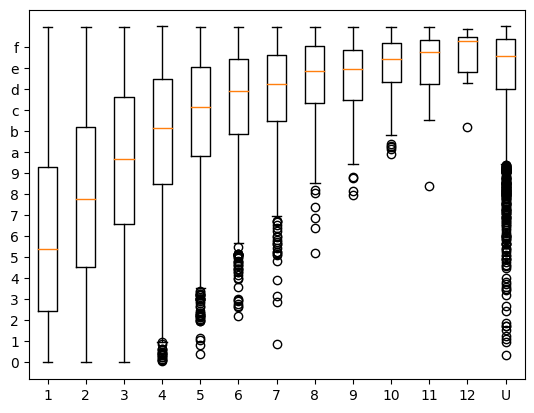

In [7]:
choices = range(1, 14)

plt.boxplot([hex_to_int(b) for b in bins])
plt.xticks(choices, list(range(1, 13)) + ['U'])
ticks_hex, labels_hex = generate_hex_labels()
plt.yticks(ticks_hex, labels_hex)
# plt.ylim(0, 4.295e9)
plt.show()

In [20]:
from gale_shapley import run_matching
from oneshot import oneshot

sel, rnk = None, None  # Stages: 1 -> (0, 0), 2 -> (0, 1), 3 -> (1, 0), 4 -> (1, 1)
adm = 3  # Policies: open -> 1, edopt -> 2, screen -> 3, combination -> None
students, schools, student_info, school_info = oneshot(seed=random_state, return_list=True, sel=sel, rnk=rnk, adm=adm)
bins, _, _ = run_matching(students, student_info, schools, school_info)
bins = dict_to_list(bins)
counts = np.array([len(bin) for bin in bins])
medians = [sorted(bin)[len(bin)//2] for bin in bins]

In [21]:
num_students = np.sum(counts)
choices = list(range(1, 13)) + [13.5]

fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(
	go.Bar(x=choices, y=counts/num_students, name='Percentage of students matched'),
	secondary_y=False)
fig.add_trace(go.Scatter(x=choices, y=hex_to_int(medians), name='Median lottery number'), secondary_y=True)

ticks_hex, labels_hex = generate_hex_labels()
fig.update_layout(
	title='Matching choice distribution - Stage 7',
	width=700,
	height=600,
	showlegend=False,
	xaxis=dict(title='Placement in ranking', tickmode='array', tickvals=choices, ticktext=choices[:-1]+['Unmatched']),
	yaxis=dict(title='Students matched', range=[0, 1], tickformat='.0%'),
	yaxis2=dict(title='Median lottery number (first digit)', tickmode='array', tickvals=ticks_hex, ticktext=labels_hex, range=[0, 4.295e9], showgrid=False),
	plot_bgcolor='rgba(0, 0, 0, 0)',
	paper_bgcolor='rgba(0, 0, 0, 0)'
)

fig.show()

In [ ]:
cumulative_bins = [bins[0]]
for i in range(1, len(bins)-1):
	cumulative_bins.append(cumulative_bins[i-1] + bins[i])

cumulative_counts = np.array([len(bin) for bin in cumulative_bins])
cumulative_averages = [average_lottery_number(bin) for bin in cumulative_bins]

In [ ]:
fig = make_subplots(specs=[[{'secondary_y': True}]])
fig.add_trace(go.Bar(x=choices[:-1], y=cumulative_counts/num_students, name='Percentage of students matched'), secondary_y=False)
fig.add_trace(go.Scatter(x=choices, y=hex_to_int(cumulative_averages), name='Average lottery number'), secondary_y=True)

fig.update_layout(
	title='Matching choice distribution',
	width=900,
	height=500,
	xaxis=dict(title='Top N positions in preference list', tickmode='array', tickvals=choices[:-1], ticktext=choices[:-1]),
	yaxis=dict(title='Students matched', tickformat='.0%'),
	yaxis2=dict(title='Average lottery number (first digit)', tickmode='array', tickvals=ticks_hex, ticktext=labels_hex, range=[0, 4.295e9])
)

fig.show()

### Aggregate stats

In [ ]:
print(f'Percentage of students matched with their first choice: {100*counts[0]/num_students:.2f}%')
print(f'\twith average lottery number (first 8 digits) {hex_to_int(averages)[0]:x}')

print(f'Percentage of students matched with a top 5 choice: {100*cumulative_counts[4]/num_students:.2f}%')
print(f'\twith average lottery number (first 8 digits) {cumulative_averages[4]}')

print(f'Percentage of students unmatched: {100*counts[-1]/num_students:.2f}%')
print(f'\twith average lottery number (first 8 digits) {hex_to_int(averages)[-1]:x}')

Percentage of students matched with their first choice: 41.77%
	with average lottery number (first 8 digits) 5c54dfb4
Percentage of students matched with a top 5 choice: 82.17%
	with average lottery number (first 8 digits) 6ecffe47
Percentage of students unmatched: 1.97%
	with average lottery number (first 8 digits) ee1807e3


In [ ]:
concat_counts = [i for i in range(1, 13) for _ in range(counts[i-1])]
median_choice = concat_counts[len(concat_counts) // 2]
median_choice

2

In [ ]:
num_students = np.sum(counts)
choice_ratio = counts[:-1] / num_students
average_choice = np.sum(choice_ratio * np.array(range(1, 13)))
average_choice

2.9029894736842103

## Plot multiple stages

In [ ]:
stages = [1, 2, 3, 4]

bins_dicts = [np.load(f'Data/Simulation/bins_stage{stage}.npy', allow_pickle=True).item() for stage in stages]
bins_mult = [dict_to_list(d) for d in bins_dicts]

counts_mult = [np.array([len(bin) for bin in bins]) for bins in bins_mult]
averages_mult = [[average_lottery_number(bin) for bin in bins] for bins in bins_mult]
medians_mult = [[sorted(bin)[len(bin)//2] for bin in bins] for bins in bins_mult]
mins_mult = [[min(bin) for bin in bins] for bins in bins_mult]
maxs_mult = [[max(bin) for bin in bins] for bins in bins_mult]

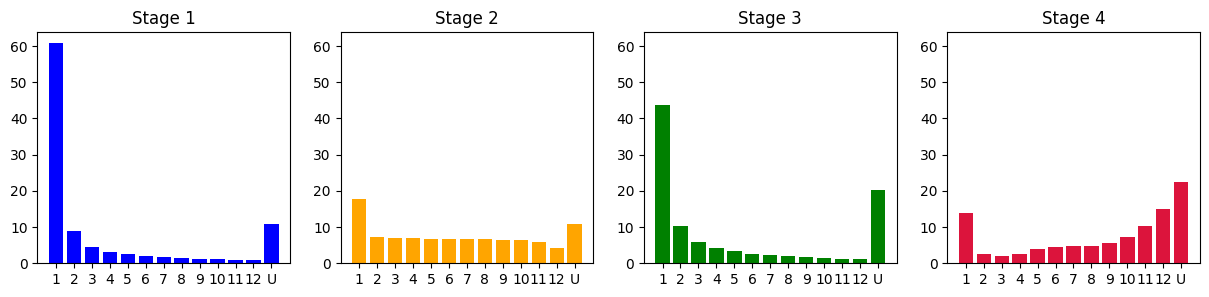

In [ ]:
num_students = np.sum(counts_mult[0])
choices = np.array(range(1, 14))

colors = ['blue', 'orange', 'green', 'crimson']
fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for stage in stages:
	axis = ax[stage-1]
	axis.bar(choices, 100*counts_mult[stage-1]/num_students, color=colors[stage-1])
	axis.set_title(f'Stage {stage}')
	axis.set_xticks(choices, list(range(1, 13)) + ['U'])

bottom, top = ax[0].get_ylim()
for axis in ax:
	axis.set_ylim(bottom, top)

plt.show()

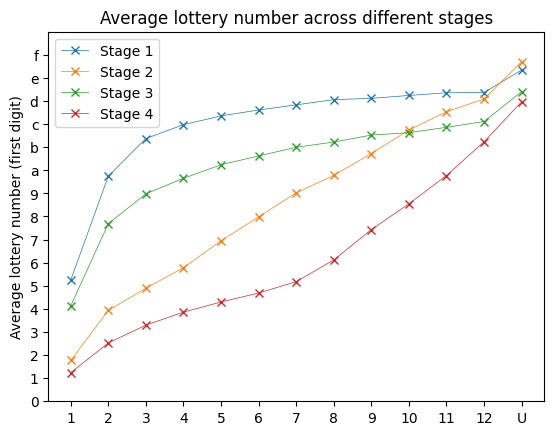

In [ ]:
for stage in stages:
	plt.plot(choices, hex_to_int(averages_mult[stage-1]), marker='x', linewidth=0.5, label=f'Stage {stage}')

plt.xticks(choices, list(range(1, 13)) + ['U'])
ticks_hex, labels_hex = generate_hex_labels()
plt.yticks(ticks_hex, labels_hex)
plt.ylim(0, 4.295e9)
plt.ylabel('Average lottery number (first digit)')
plt.legend()
plt.title('Average lottery number across different stages')
plt.show()

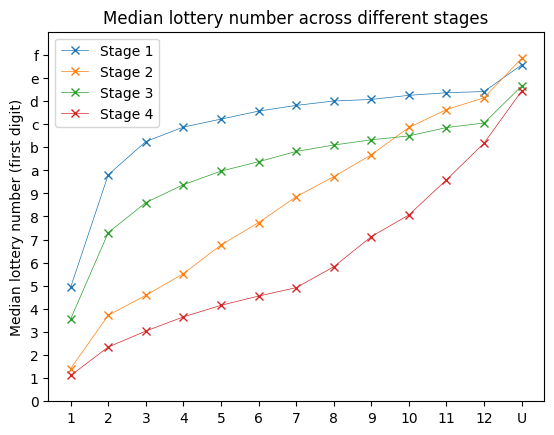

In [ ]:
for stage in stages:
	plt.plot(choices, hex_to_int(medians_mult[stage-1]), marker='x', linewidth=0.5, label=f'Stage {stage}')

plt.xticks(choices, list(range(1, 13)) + ['U'])
ticks_hex, labels_hex = generate_hex_labels()
plt.yticks(ticks_hex, labels_hex)
plt.ylim(0, 4.295e9)
plt.ylabel('Median lottery number (first digit)')
plt.legend()
plt.title('Median lottery number across different stages')
plt.show()

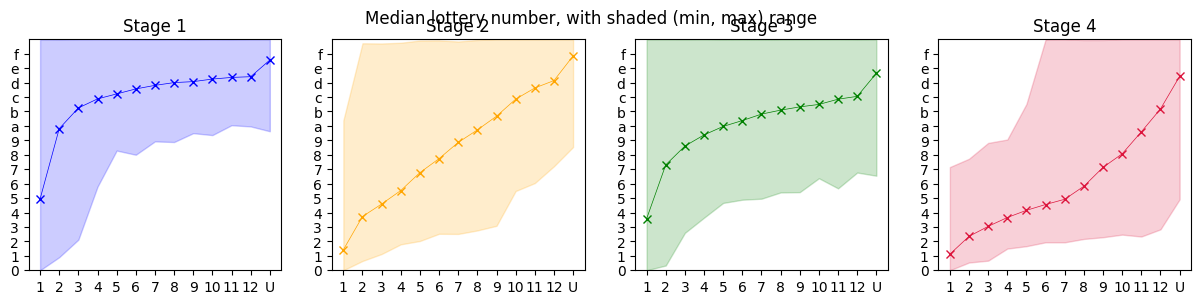

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 3))

for stage in stages:
	axis = ax[stage-1]
	axis.plot(choices, hex_to_int(medians_mult[stage-1]), marker='x', linewidth=0.5, color=colors[stage-1])
	axis.fill_between(choices, hex_to_int(mins_mult[stage-1]), hex_to_int(maxs_mult[stage-1]), alpha=.2, color=colors[stage-1])
	axis.set_title(f'Stage {stage}')
	axis.set_xticks(choices, list(range(1, 13)) + ['U'])
	ticks_hex, labels_hex = generate_hex_labels()
	axis.set_yticks(ticks_hex, labels_hex)

bottom, top = 0, 4.295e9
for axis in ax:
	axis.set_ylim(bottom, top)

fig.suptitle('Median lottery number with shaded (min, max) range')
plt.show()